In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import scipy
import scipy.integrate
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from numba import *
from clvlib.numpy import *
from scipy.integrate import odeint

In [2]:
def L96(x, t, F=8):
    """Lorenz 96 model with constant forcing"""
    return (np.roll(x, -1) - np.roll(x, 2)) * np.roll(x, 1) - x + F 


def lorenz96_jacobian(_: float, x: np.ndarray, forcing=8) -> np.ndarray:  # noqa: ARG001
    """Jacobian matrix of the Lorenz-96 system (pure NumPy)."""
    k = x.size
    jac = np.zeros((k, k), dtype=np.float64)

    idx = np.arange(k)
    im1 = (idx - 1) % k
    im2 = (idx - 2) % k
    ip1 = (idx + 1) % k

    jac[idx, im1] = x[ip1] - x[im2]
    jac[idx, ip1] = x[im1]
    jac[idx, im2] = -x[im1]
    jac[idx, idx] = -1.0
    return jac

In [3]:
# These are our constants
N = 100  # Number of variables
F = 8  # Forcing

x0 = F * np.ones(N)  # Initial state (equilibrium)
x0[0] += 0.01  # Add small perturbation to the first variable
t = np.arange(0.0, 30.0, 0.01)

x = odeint(L96, x0, t)

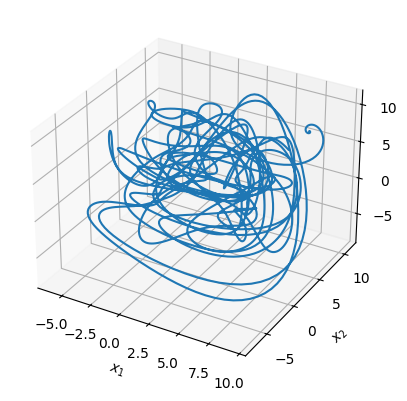

In [4]:
# Plot the first three variables
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(x[:, 0], x[:, 1], x[:, 2])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()

In [5]:
def lorenz96(t, x, F=8):
    """Lorenz 96 model with constant forcing"""
    return (np.roll(x, -1) - np.roll(x, 2)) * np.roll(x, 1) - x + F 

def lorenz96_jacobian(_: float, x: np.ndarray, forcing=8) -> np.ndarray:  # noqa: ARG001
    """Jacobian matrix of the Lorenz-96 system (pure NumPy)."""
    k = x.size
    jac = np.zeros((k, k), dtype=np.float64)

    idx = np.arange(k)
    im1 = (idx - 1) % k
    im2 = (idx - 2) % k
    ip1 = (idx + 1) % k

    jac[idx, im1] = x[ip1] - x[im2]
    jac[idx, ip1] = x[im1]
    jac[idx, im2] = -x[im1]
    jac[idx, idx] = -1.0
    return jac

In [6]:
Q, R, LE, LE_history, CLVs = lyap_analysis(lorenz96, lorenz96_jacobian, x.T, t, F, k_step=1)

/Users/riccardoconsonni/Desktop/Code/Code/clvlib/clvlib/numpy/lyap_fun.py:279: RuntimeWarning: divide by zero encountered in matmul
  K1 = dt * (Df(t, x, *args) @ V)
/Users/riccardoconsonni/Desktop/Code/Code/clvlib/clvlib/numpy/lyap_fun.py:279: RuntimeWarning: overflow encountered in matmul
  K1 = dt * (Df(t, x, *args) @ V)
/Users/riccardoconsonni/Desktop/Code/Code/clvlib/clvlib/numpy/lyap_fun.py:279: RuntimeWarning: invalid value encountered in matmul
  K1 = dt * (Df(t, x, *args) @ V)
/Users/riccardoconsonni/Desktop/Code/Code/clvlib/clvlib/numpy/lyap_fun.py:280: RuntimeWarning: divide by zero encountered in matmul
  K2 = dt * (Df(t + 0.5*dt, x + 0.5*k1, *args) @ (V + 0.5*K1))
/Users/riccardoconsonni/Desktop/Code/Code/clvlib/clvlib/numpy/lyap_fun.py:280: RuntimeWarning: overflow encountered in matmul
  K2 = dt * (Df(t + 0.5*dt, x + 0.5*k1, *args) @ (V + 0.5*K1))
/Users/riccardoconsonni/Desktop/Code/Code/clvlib/clvlib/numpy/lyap_fun.py:280: RuntimeWarning: invalid value encountered in m

In [19]:
np.shape(LE_history)

(5, 3000)

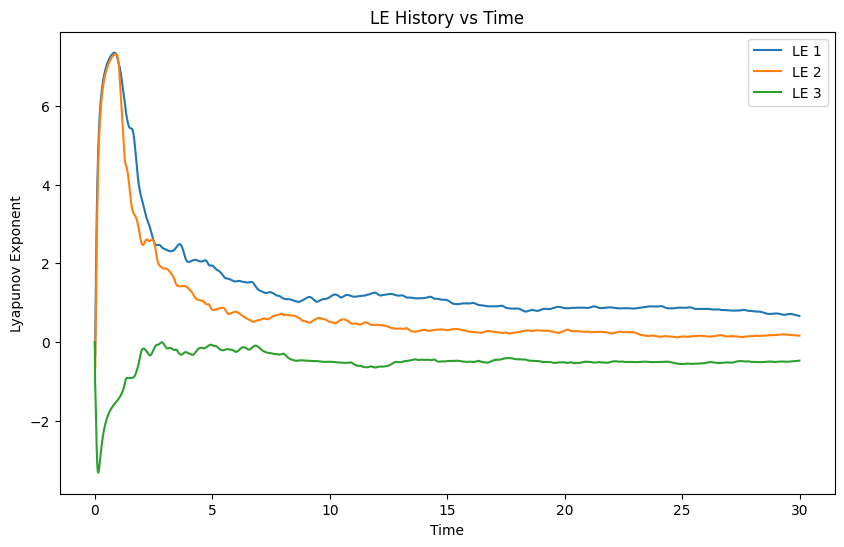

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(t, LE_history[0, :], label='LE 1')
plt.plot(t, LE_history[1, :], label='LE 2')
plt.plot(t, LE_history[2, :], label='LE 3')
plt.xlabel('Time')
plt.ylabel('Lyapunov Exponent')
plt.title('LE History vs Time')
plt.legend()
plt.show()

In [21]:
print("Final Lyapunov Exponents:", LE)

Final Lyapunov Exponents: [ 0.66173448  0.16424307 -0.47178223 -1.67289694 -3.68129697]


In [24]:
ICLE = compute_ICLE(lorenz96_jacobian, x.T, t, CLVs,  k_step=1)

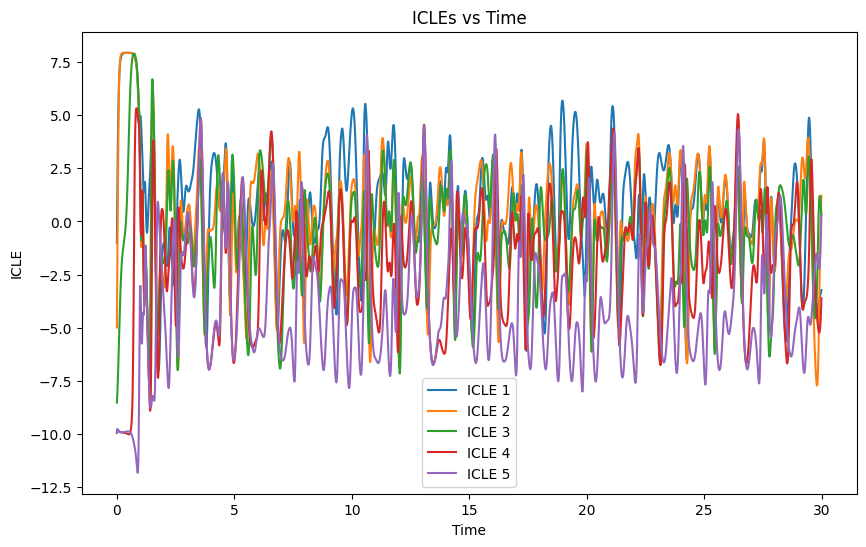

In [28]:
plt.figure(figsize=(10, 6))
for i in range(ICLE.shape[0]):
    plt.plot(t, ICLE[i, :], label=f"ICLE {i+1}")
plt.xlabel("Time")
plt.ylabel("ICLE")
plt.title("ICLEs vs Time")
plt.legend()
plt.show()

In [13]:
mean_ICLE = np.mean(ICLE, axis=1)
print("Time mean of the ICLEs:", mean_ICLE)

Time mean of the ICLEs: [  0.7112754   -0.54681234 -14.88781692]


In [25]:
V1 = CLVs[:,1:,:]
V2 = CLVs[:,:1,:]

In [26]:
theta = principal_angles(V1, V2)

In [27]:
np.shape(theta)

(1, 3000)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t, theta[0, :])
plt.xlabel("Time")
plt.ylabel("Theta")
plt.title("Theta vs Time")
plt.show()